# Classification with Virtual Branching

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
from vbranch.callbacks import classification_acc
from vbranch.applications.fcn import SimpleFCNv1, SimpleFCNv2
from vbranch.applications.cnn import SimpleCNNSmall
from vbranch.losses import softmax_cross_entropy_with_logits

from vbranch.utils import TFSessionGrow, restore_sess
from vbranch.utils.training import get_data, bag_samples, get_data_iterator

In [3]:
SAVE = False
MODEL_ID = 1
ARCHITECTURE = 'fcn'
DATASET = 'mnist'
NUM_CLASSES = 10
NUM_FEATURES = None
SAMPLES_PER_CLASS = None
BAGGING_SAMPLES = 1.
TRAIN_FRAC = 0.01

BATCH_SIZE = 32
EPOCHS = 20
STEPS_PER_EPOCH = 100

In [6]:
# Note models from experiments will be saved in separate format
if not os.path.isdir('models'):
    os.system('mkdir models')

model_name = 'vb-{}-{}-B{:d}-S{:.2f}_{:d}'.format(DATASET, ARCHITECTURE,
                                                  NUM_BRANCHES, SHARED_FRAC, MODEL_ID)
model_path = os.path.join('models', model_name)
print('Model path:', model_path)

Model path: models/mnist-fcn_1


## Training

In [ ]:
def build_model(shared_frac, name='model'):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        if ARCHITECTURE == 'fcn':
            model = SimpleFCNv1(inputs, NUM_CLASSES, name=name, shared_frac=shared_frac)
        elif ARCHITECTURE == 'fcn2':
            model = SimpleFCNv2(inputs, NUM_CLASSES, name=name, shared_frac=shared_frac)
        elif ARCHITECTURE == 'cnn':
            model = SimpleCNNSmall(inputs, NUM_CLASSES, name=name, shared_frac=shared_frac)
        else:
            raise ValueError('invalid model')

        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        model.compile(optimizer, softmax_cross_entropy_with_logits(), 
                      train_init_op, test_init_op, labels=labels, 
                      callbacks={'acc':classification_acc(NUM_BRANCHES)})

    model.summary()
    return model

In [9]:
(X_train, y_train), (X_test, y_test) = get_data(DATASET, ARCHITECTURE, NUM_CLASSES,
                                                NUM_FEATURES, SAMPLES_PER_CLASS, 
                                                train_frac=TRAIN_FRAC)
# Bagging
if BAGGING_SAMPLES < 1:
    x_train_list, y_train_list = bag_samples(X_train, y_train, NUM_BRANCHES, 
                                             max_samples=BAGGING_SAMPLES)

def train():
    inputs, labels, train_init_op, test_init_op = get_data_iterator(x_shape, y_shape, 
                                                                    batch_size=BATCH_SIZE, 
                                                                    n=NUM_BRANCHES, 
                                                                    share_xy=BAGGING_SAMPLES == 1)

    if NUM_BRANCHES == 1 or BAGGING_SAMPLES == 1:
        train_dict = {'x:0': X_train, 'y:0': y_train, 'batch_size:0': BATCH_SIZE}
    else:
        train_dict = {}
        for i in range(NUM_BRANCHES):
            train_dict['vb{}_x:0'.format(i+1)] = x_train_list[i]
            train_dict['vb{}_y:0'.format(i+1)] = y_train_list[i]
        train_dict['batch_size:0'] = BATCH_SIZE

    val_dict = {'x:0': X_test, 'y:0': y_test, 'batch_size:0': len(X_test)}

    history = model.fit(EPOCHS, STEPS_PER_EPOCH, train_dict=train_dict,
                        val_dict=val_dict, log_path=model_path if SAVE else None)
    return history

i  Layer name                Output shape  Parameters       Num param  Inbound  
--------------------------------------------------------------------------------
   Input                     [None,784]                                         
--------------------------------------------------------------------------------
0  fc1 (Dense)               [None,512]    [784,512] [512]  401920     input:0  
--------------------------------------------------------------------------------
1  bn1 (BatchNormalization)  [None,512]    [512] [512]      1024       fc1      
--------------------------------------------------------------------------------
2  relu1 (Activation)        [None,512]                     0          bn1      
--------------------------------------------------------------------------------
3  output (Dense)            [None,10]     [512,10] [10]    5130       relu1    
--------------------------------------------------------------------------------
Total parameters: 408074


## Evaluation

In [6]:
from vbranch.utils.generic import get_model_path, get_vb_model_path
from vbranch.utils.test import baseline_classification, compute_correlation_strength, compute_acc_from_logits

### Correlation and Strength

For classification, we can compute the correlation between models and their strength. The formulas used are from the Random Forest paper:

https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf

In [12]:
# Baseline

y_labels = np.argmax(y_test, axis=-1)

model_id_list = range(1, 9)
output_list = []
acc_list = []
pred_list = []

for model_id in model_id_list:
    tf.reset_default_graph()

    with tf.Session() as sess:
        model_path = get_model_path(DATASET, ARCHITECTURE, NUM_CLASSES, 
                                    SAMPLES_PER_CLASS, model_id=model_id)
        restore_sess(sess, model_path)
        sess.run('test_init_op', feed_dict={'x:0':X_test, 'y:0': y_test, 
                                        'batch_size:0':len(X_test)})
        output = sess.run('model/output/output:0'.format(model_id))

    output_list.append(output)
    acc_list.append(compute_acc_from_logits(output, y_test, NUM_CLASSES))
    pred_list.append(np.argmax(output, axis=1))
    
model_preds = np.array(pred_list).transpose(1,0)
baseline_corr, baseline_strength = compute_correlation_strength(model_preds, y_labels, 
                                                                NUM_CLASSES, 
                                                                len(model_id_list))

print('Mean correlation:', baseline_corr)
print('Strength:' , baseline_strength)

INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_4/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_5/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_6/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_7/ckpt
INFO:tensorflow:Restoring parameters from models/mnist-fcn2/model_8/ckpt
Mean correlation: 0.5901408352877151
Strength: 0.8988125


In [13]:
# Virtual branching

shared_frac_list = [0, 0.25, 0.5, 0.75, 1.]
shared_correlation_list = []
shared_strength_list = []

for shared in shared_frac_list:
    mean_correlation_list = []
    strength_list = []
    
    for model_id in range(1, 5):
        model_path = get_vb_model_path(DATASET, ARCHITECTURE, NUM_BRANCHES, shared, 
                                       NUM_CLASSES, SAMPLES_PER_CLASS, model_id=model_id)

        test_init_ops = []
        tensors = []
        for i in range(NUM_BRANCHES):
            test_init_ops.append('test_init_op_{}'.format(i+1))
            tensors.append('model/output/vb{}/output:0'.format(i+1))

        tf.reset_default_graph()

        with tf.Session() as sess:
            restore_sess(sess, model_path)
            sess.run(test_init_ops, feed_dict={'x:0':X_test, 'y:0': y_test, 
                                        'batch_size:0':len(X_test)})
            outputs = sess.run(tensors)
            
        preds = np.array([np.argmax(x, axis=1) for x in outputs]).transpose(1,0)
        mean_correlation, strength = compute_correlation_strength(preds, y_labels, 
                                                                  NUM_CLASSES, NUM_BRANCHES)
        mean_correlation_list.append(mean_correlation)
        strength_list.append(strength)
        
    shared_correlation_list.append([np.mean(mean_correlation_list), np.std(mean_correlation_list)])
    shared_strength_list.append([np.mean(strength_list), np.std(strength_list)])

INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2/S0.00/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2/S0.00/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2/S0.00/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2/S0.00/model_4/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2/S0.25/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2/S0.25/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2/S0.25/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2/S0.25/model_4/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2/S0.50/model_1/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2/S0.50/model_2/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2/S0.50/model_3/ckpt
INFO:tensorflow:Restoring parameters from models/vb-mnist-fcn2/B2

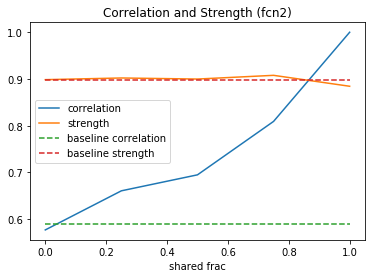

In [19]:
plt.plot(shared_frac_list, np.array(shared_correlation_list)[:, 0], label='correlation')
plt.plot(shared_frac_list, np.array(shared_strength_list)[:, 0], label='strength')

# Baseline
plt.plot(shared_frac_list, [baseline_corr]* len(shared_correlation_list), 
         label='baseline correlation', linestyle='--')
plt.plot(shared_frac_list, [baseline_strength]* len(shared_correlation_list), 
         label='baseline strength', linestyle='--')

plt.xlabel('shared frac')
plt.title('Correlation and Strength ({})'.format(ARCHITECTURE))
plt.legend()

plt.savefig('figs/correlation-strength.png')
plt.show()

### Model Parameters

In [4]:
tf.reset_default_graph()
inputs = tf.placeholder('float32', [None, 28,28,1])

# Baseline
model = SimpleCNNSmall(inputs, NUM_CLASSES)
baseline_params = model.count_parameters()
print('Baseline parameters:', baseline_params)

Instructions for updating:
Colocations handled automatically by placer.
Baseline parameters: 18010


In [5]:
# Vbranch params
shared_frac_list = [0, 0.25, 0.5, 0.75, 1.]

vbranch_params = []
for frac in shared_frac_list:
    tf.reset_default_graph()
    with tf.variable_scope('model', reuse=tf.AUTO_REUSE):
        inputs = tf.placeholder('float32', [None, 28,28,1])
        model = SimpleCNNSmall([inputs]*NUM_BRANCHES, NUM_CLASSES, shared_frac=frac)
    vbranch_params.append(model.count_parameters())

In [6]:
param_ratio = [p / baseline_params for p in vbranch_params]
ideal_ratio = NUM_BRANCHES - np.array(shared_frac_list)**2 * (NUM_BRANCHES-1)

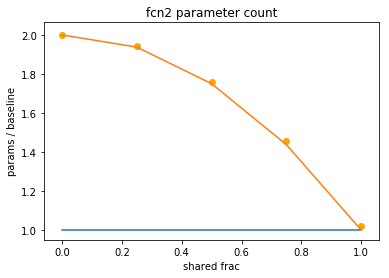

In [7]:
plt.scatter(shared_frac_list, param_ratio, color='orange')
plt.plot(shared_frac_list, [1]*len(shared_frac_list))
plt.plot(shared_frac_list, ideal_ratio)

plt.xlabel('shared frac')
plt.ylabel('params / baseline')
plt.title('{} parameter count'.format(ARCHITECTURE))

plt.savefig('figs/cnn-small-parameter-count.png')
plt.show()